In [ ]:
# (Node) Degree Centrality Analysis

## Introduction

In this notebook, we will do an analysis on the degree centrality of our network, that was scrapped from Reddit.

To get started, let us first state some definitions and facts, which were taken from the Slides of Dr. Khayati from the University of Fribourg. We will denote such pieces of information within a quote block.

> Definition
> Centrality measures are used to define the central node which:
> - is important and/or powerful
> - has an influential/advantageous position on the network

To analyse our network for centrality makes a lot of sense. Since our network represents the interaction between different reddit users, we can analyse the network for influental users.

> There most common centrality measures are:
> - Based on degree: Degree centrality
> - Based on geodesics: Closeness and Betweenness
> - Recursive: Eigenvector and PageRank

We will treat in this document the analysis based on degree. Please refer to the report for the PageRang analysis and more.


#### Node Degree Centrality

First, let us refer to slide 7 of SL03:
> Idea: A central actor is the one that has many connections.
>
> Definition:
> - The degree of centrality $d(v_i)$ of a node $v_i$ is the number of
ties that vi has in the network.
> - In social media networks, $d(v_i)$ represents the number of
friends person $v_i$ has.

In our network, $d(v_i)$ doesn't represent the number of friends, since Reddit doesn't have any notion of friends. In our data model, $d(v_i)$ rerpresents the number of different users who commented on user $v_i$.

Also, let us note here that our data model is a *directed* graph. This means that we need to define the notion of centrality a bit more rigorous. From the slides, we have that:

> In directed graphs, the degree centrality value is computed using the in-degree, the out-degree, or the combination.

In this analysis, we will do an analysis on both: the sum of the degrees, the in-degrees and the out-degrees.

## The degree preprocessing

We will consider for the computations here a small graph. We will load our social media network at a later point.

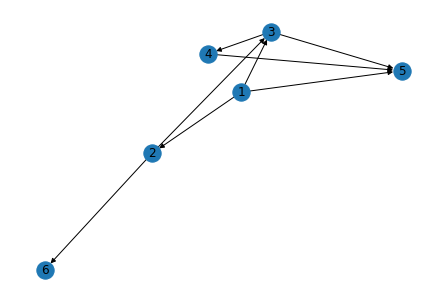

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.add_edge(1, 2)
G.add_edge(1, 3)
G.add_edge(1, 5)
G.add_edge(2, 3)
G.add_edge(3, 4)
G.add_edge(4, 5)
G.add_edge(3, 5)
G.add_edge(2, 6)

nx.draw(G, with_labels=True)

We suppose here also that the graph to be analysed has been loaded into a `nx.Graph` or `nx.DiGraph` object. To make computations easier and most importantly **faster**, we will use here `pandas` instead of an own implementation.

First, we have to preprocess our node degrees into a pandas `DataFrame`. We will consider now only the case for a `nx.DiGraph`.

In [2]:
import pandas as pd

degrees = [dict(G.degree()), dict(G.in_degree()), dict(G.out_degree())]

#prepare our data to load into pandas
data = {}
for k in degrees[0].keys():
    #by creating tuples of (id, degree, in_degree, out_degree)
    data[k] = tuple(d[k] for d in degrees)

df = pd.DataFrame.from_dict(data, columns=["degree", "in_degree", "out_degree"], orient='index')
df.index.name = "node"

df

,degree,in_degree,out_degree
node,,,
1,3,0,3
2,3,1,2
3,4,2,2
5,3,3,0
4,2,1,1
6,1,1,0


## Normalizing the degree centrality

As it's often useful to normalize data, we do this here with three different techniques.

#### Normalization by the maximum possible degree
\begin{equation}
\tilde{d}\left(v_{i}\right)=\frac{d\left(v_{i}\right)}{n-1}
\end{equation}


In [3]:
n = G.number_of_nodes()
df['deg_centr_max_poss_degree'] = df['degree']/(n-1)
df

,degree,in_degree,out_degree,deg_centr_max_poss_degree
node,,,,
1,3,0,3,0.6
2,3,1,2,0.6
3,4,2,2,0.8
5,3,3,0,0.6
4,2,1,1,0.4
6,1,1,0,0.2


#### Normalization by the maximum degree
\begin{equation}
d^{\max }\left(v_{i}\right)=\frac{d\left(v_{i}\right)}{\max _{j, j \in\{1, n\}} d\left(v_{j}\right)}
\end{equation}


In [4]:
max_degree = df['degree'].max()
df['deg_centr_max_degree'] = df['degree']/max_degree
df

,degree,in_degree,out_degree,deg_centr_max_poss_degree,deg_centr_max_degree
node,,,,,
1,3,0,3,0.6,0.75
2,3,1,2,0.6,0.75
3,4,2,2,0.8,1.00
5,3,3,0,0.6,0.75
4,2,1,1,0.4,0.50
6,1,1,0,0.2,0.25


#### Normalization by the degree sum

$$
d^{s u m}\left(v_{i}\right)=\frac{d\left(v_{i}\right)}{\sum_{j, j \in\{1, n\}} d\left(v_{j}\right)}=\frac{d\left(v_{i}\right)}{2 \times|E|}=\frac{d\left(v_{i}\right)}{2 \times m}
$$


In [5]:
df['deg_centr_degree_sum'] = df['degree']/G.number_of_edges()
df

,degree,in_degree,out_degree,deg_centr_max_poss_degree,deg_centr_max_degree,deg_centr_degree_sum
node,,,,,,
1,3,0,3,0.6,0.75,0.375
2,3,1,2,0.6,0.75,0.375
3,4,2,2,0.8,1.00,0.500
5,3,3,0,0.6,0.75,0.375
4,2,1,1,0.4,0.50,0.250
6,1,1,0,0.2,0.25,0.125


## Graph Degree Centrality

> The centrality of a graph is a degree vector V that contains
the degree centrality of all nodes.
> Let A be the adjacency matrix of a undirected graph and
let $U \in \mathbb{R}^n$ be the ones vector (all ones). Then,
> $$V = A \cdot U$$


In [6]:
A = nx.to_numpy_matrix(G)
U = [1]*n
V = A.dot(U)
V

matrix([[3., 2., 2., 0., 1., 0.]])

## Code Summary: A class
We can summarize this snippets into a small class.

In [7]:
class DegreeCentrality:
    
    def __init__(self):
        pass
    
    def compute_degree_centrality(self, G):
        self.n = G.number_of_nodes()
        self.G = G
        
        #load graph
        if isinstance(G, nx.DiGraph):
            self.load_digraph(G)
        else:
            self.load_graph(G)
            
        #compute degree stats
        self.df['deg_centr_max_poss_degree'] = self.df['degree']/(self.n-1)
        
        max_degree = self.df['degree'].max()
        self.df['deg_centr_max_degree'] = self.df['degree']/max_degree
        
        deg_sum = self.df['degree'].max()
        self.df['deg_centr_max_degree'] = self.df['degree']/max_degree
        
        self.df['deg_centr_degree_sum'] = self.df['degree']/G.number_of_edges()
        
        
        if self.digraph:
            self.df['deg_centr_max_degree_out'] = self.df['out_degree']/max_degree
            self.df['deg_centr_max_degree_in'] = self.df['in_degree']/max_degree
            
            self.df['deg_centr_max_poss_degree_out'] = self.df['out_degree']/(self.n-1)
            self.df['deg_centr_max_poss_degree_in'] = self.df['in_degree']/(self.n-1)

            self.df['deg_centr_degree_sum_out'] = self.df['out_degree']/G.number_of_edges()
            self.df['deg_centr_degree_sum_in'] = self.df['in_degree']/G.number_of_edges()
            
            
        return self.df
       
    
    def load_digraph(self, G):
        self.digraph = True
        degrees = [dict(G.degree()), dict(G.in_degree()), dict(G.out_degree())]
        data = {}
        for k in degrees[0].keys():
            data[k] = tuple(d[k] for d in degrees)
        
        self.df = pd.DataFrame.from_dict(data, columns=["degree", "in_degree", "out_degree"], orient='index')
        
            
    def load_graph(self, G):
        self.digraph = False
        self.df = pd.DataFrame.from_dict(dict(G.degree()), columns=["degree"], orient='index')
        
        
    def graph_degree_centrality(self):
        return nx.to_numpy_matrix(G).dot([1]*self.n)

## Application on our network

For this, we will now load our network data.
We have multiple data models. We're going to choose the `deep_link_no_merge` model. Please refer to the report for more details.

In [8]:
edges = pd.read_csv('../data/csv/edges_deep_link_no_merge.csv')
G = nx.from_pandas_edgelist(edges, create_using=nx.DiGraph(), source='source', target='target', edge_attr=['score', 'weight', 'time', 'sub'])

In [9]:
dc = DegreeCentrality()
df = dc.compute_degree_centrality(G)
df

,degree,in_degree,out_degree,deg_centr_max_poss_degree,deg_centr_max_degree,deg_centr_degree_sum,deg_centr_max_degree_out,deg_centr_max_degree_in,deg_centr_max_poss_degree_out,deg_centr_max_poss_degree_in,deg_centr_degree_sum_out,deg_centr_degree_sum_in
amorydmart,6,5,1,0.000233,0.005581,0.000076,0.000930,0.004651,0.000039,0.000194,0.000013,0.000063
Stevenlerma10,37,35,2,0.001438,0.034419,0.000470,0.001860,0.032558,0.000078,0.001361,0.000025,0.000444
azn1217,3,0,3,0.000117,0.002791,0.000038,0.002791,0.000000,0.000117,0.000000,0.000038,0.000000
DanAlucard,23,3,20,0.000894,0.021395,0.000292,0.018605,0.002791,0.000778,0.000117,0.000254,0.000038
MuscleHour479,17,4,13,0.000661,0.015814,0.000216,0.012093,0.003721,0.000505,0.000156,0.000165,0.000051
...,...,...,...,...,...,...,...,...,...,...,...,...
vicious_delicious_77,3,0,3,0.000117,0.002791,0.000038,0.002791,0.000000,0.000117,0.000000,0.000038,0.000000
Devilstangs2,3,0,3,0.000117,0.002791,0.000038,0.002791,0.000000,0.000117,0.000000,0.000038,0.000000
Please_Stop_Posting-,1,0,1,0.000039,0.000930,0.000013,0.000930,0.000000,0.000039,0.000000,0.000013,0.000000
aoskiev,1,0,1,0.000039,0.000930,0.000013,0.000930,0.000000,0.000039,0.000000,0.000013,0.000000


Now, let's sort the data by some column

,degree,in_degree,out_degree,deg_centr_max_poss_degree,deg_centr_max_degree,deg_centr_degree_sum,deg_centr_max_degree_out,deg_centr_max_degree_in,deg_centr_max_poss_degree_out,deg_centr_max_poss_degree_in,deg_centr_degree_sum_out,deg_centr_degree_sum_in
rBitcoinMod,1075,1075,0,0.041793,1.000000,0.013646,0.000000,1.000000,0.000000,0.041793,0.000000,0.013646
AutoModerator,823,61,762,0.031996,0.765581,0.010447,0.708837,0.056744,0.029624,0.002372,0.009673,0.000774
Reahvenz,625,624,1,0.024298,0.581395,0.007934,0.000930,0.580465,0.000039,0.024259,0.000013,0.007921
bitusher,581,179,402,0.022588,0.540465,0.007375,0.373953,0.166512,0.015629,0.006959,0.005103,0.002272
42points,535,530,5,0.020799,0.497674,0.006791,0.004651,0.493023,0.000194,0.020605,0.000063,0.006728
...,...,...,...,...,...,...,...,...,...,...,...,...
twe1veleven,1,0,1,0.000039,0.000930,0.000013,0.000930,0.000000,0.000039,0.000000,0.000013,0.000000
Nigel_Hyndman,1,0,1,0.000039,0.000930,0.000013,0.000930,0.000000,0.000039,0.000000,0.000013,0.000000
crypt0noob,1,0,1,0.000039,0.000930,0.000013,0.000930,0.000000,0.000039,0.000000,0.000013,0.000000
Moist_Sleep_3081,1,0,1,0.000039,0.000930,0.000013,0.000930,0.000000,0.000039,0.000000,0.000013,0.000000


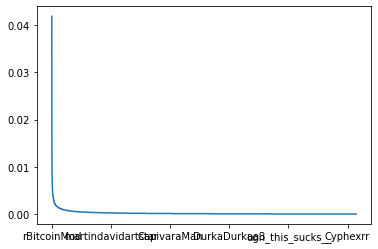

In [10]:
s = df.sort_values(by='deg_centr_max_poss_degree', ascending=False)
s['deg_centr_max_poss_degree'].plot()
s

In [13]:
import numpy as np
def plot_degree_histogram(g, normalized=True):
    aux_y = nx.degree_histogram(g)
    aux_x = np.arange(0, len(aux_y)).tolist()
    n_nodes = g.number_of_nodes()
    if normalized:
        for i in range(len(aux_y)):
            aux_y[i] = aux_y[i]/n_nodes
    return aux_x, aux_y

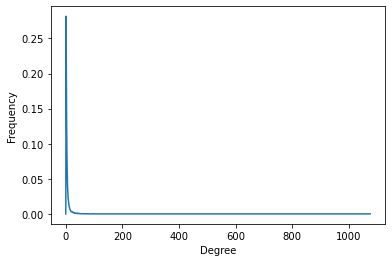

In [22]:
import seaborn as sns
x,y = plot_degree_histogram(G)
ax=sns.lineplot(x=x,y=y)
ax.set(xlabel="Degree", ylabel="Frequency")
plt.savefig("../data/images/deg_dist.pdf")

We can clearly see that the nodes follow a power law distribution.

We could now filter the users by some criteria about their node degree. E.g.

In [14]:
s[s['deg_centr_max_degree'] > 0.2]

,degree,in_degree,out_degree,deg_centr_max_poss_degree,deg_centr_max_degree,deg_centr_degree_sum,deg_centr_max_degree_out,deg_centr_max_degree_in,deg_centr_max_poss_degree_out,deg_centr_max_poss_degree_in,deg_centr_degree_sum_out,deg_centr_degree_sum_in
rBitcoinMod,1075,1075,0,0.041793,1.000000,0.013646,0.000000,1.000000,0.000000,0.041793,0.000000,0.013646
AutoModerator,823,61,762,0.031996,0.765581,0.010447,0.708837,0.056744,0.029624,0.002372,0.009673,0.000774
Reahvenz,625,624,1,0.024298,0.581395,0.007934,0.000930,0.580465,0.000039,0.024259,0.000013,0.007921
bitusher,581,179,402,0.022588,0.540465,0.007375,0.373953,0.166512,0.015629,0.006959,0.005103,0.002272
42points,535,530,5,0.020799,0.497674,0.006791,0.004651,0.493023,0.000194,0.020605,0.000063,0.006728
jakkkmotivator,489,489,0,0.019011,0.454884,0.006207,0.000000,0.454884,0.000000,0.019011,0.000000,0.006207
frank__costello,432,272,160,0.016795,0.401860,0.005484,0.148837,0.253023,0.006220,0.010575,0.002031,0.003453
Kiwip0rn,379,116,263,0.014734,0.352558,0.004811,0.244651,0.107907,0.010225,0.004510,0.003338,0.001472
KAX1107,378,377,1,0.014696,0.351628,0.004798,0.000930,0.350698,0.000039,0.014657,0.000013,0.004786
liquid_at,327,87,240,0.012713,0.304186,0.004151,0.223256,0.080930,0.009331,0.003382,0.003047,0.001104


## Summary

We discovered the most influential users using the node degree centrality. However, we need to keep in mind that some of these users are bots like moderator bots who automatically comment on certain posts. To filter out these, we need more advanced techniques and most likely also a bit of ML, as the Reddit API doesn't distinguish between user or bot/moderator comments.